# <b><u>This notebook is still work in progress</b></u>

Here we attempt to perform Time Series seasonal decomposition. This will be done on "non stationary" (raw) and stationary datasets. It is expected that the results will be better After the time series are made to be stationary.

<a id="top"></a>  
1. [Data collection and Processing](#01)  
1. [Seasonal decomposition (non stationary data)](#02) 
1. [Make Time Series stationary](#03)  
1. [Seasonal decomposition (stationary data)](#04)  

<a id="01"></a> 
# Data collection and processing
[back to top](#top)

Data colelction and processing is identical to the one in the previous notebook. It would be beneficial to create a separate helper function for this procedure, however I decided to repeat it here for clarity reasons.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
#import mpld3
#mpld3.enable_notebook()

msft = yf.Ticker("MSFT")

# get historical market data
data = msft.history(period="max")

data = data.loc["2010-01-01":].copy()

In [2]:
hist = data.copy(deep=True)
hist["Tomorrow"] = hist["Close"].shift(-1)
hist["Target"] = (hist["Tomorrow"] > hist["Close"]).astype(int) 
#1 if followind day price incresed, 0 otherwise

horizons = [2,5,60,250,1000]

for horizon in horizons:
    rolling_averages = hist.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    hist[ratio_column] = hist["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    hist[trend_column] = hist.shift(1).rolling(horizon).sum()["Target"]
    
hist['SMA10'] = hist['Close'].rolling(10).mean()
hist['Dec_SMA10'] = (hist.SMA10 < hist.SMA10.shift(10)).astype(int);

hist['SMA30'] = hist['Close'].rolling(30).mean()
hist['Dec_SMA30'] = (hist.SMA30 < hist.SMA30.shift(30)).astype(int);

hist['SMA100'] = hist['Close'].rolling(100).mean()
hist['Dec_SMA100'] = (hist.SMA100 < hist.SMA100.shift(100)).astype(int);


In [3]:
try:
    del hist['Dividends']
    del hist['Stock Splits']
except:
    pass

In [4]:
from typing import Callable
# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
    # Get the difference in price from previous step
    delta = over.diff()
    # Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])
    rsi.name = 'rsi'

    # Assert range
    valid_rsi = rsi[length - 1:]
    assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi

In [5]:
# Window length for moving average
lengths = [10,30]
# Calculate RSI using MA of choice
for length in lengths:
    # Reminder: Provide ≥ `1 + length` extra data points!
    hist['rsi_ema_'+str(length)] = calc_rsi(hist['Close'], lambda s: s.ewm(span=length).mean())
    hist['rsi_sma_'+str(length)] = calc_rsi(hist['Close'], lambda s: s.rolling(length).mean())
    hist['rsi_rma_'+str(length)] = calc_rsi(hist['Close'], lambda s: s.ewm(alpha=1 / length).mean())  

In [6]:
hist = hist.dropna()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_df = hist.copy(deep=True)
scaled_df[scaled_df.columns] = scaler.fit_transform(scaled_df[scaled_df.columns])

In [8]:
scaled_df.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,SMA30,Dec_SMA30,SMA100,Dec_SMA100,rsi_ema_10,rsi_sma_10,rsi_rma_10,rsi_ema_30,rsi_sma_30,rsi_rma_30
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-23 00:00:00-05:00,0.005291,0.002538,0.005024,0.004203,0.090740,0.005382,1.0,0.528400,0.5,0.524579,...,0.002803,0.0,0.000000,0.0,0.356419,0.189221,0.325889,0.345389,0.369442,0.408013
2013-12-24 00:00:00-05:00,0.005062,0.003242,0.005259,0.005382,0.034944,0.006305,1.0,0.587971,0.5,0.576184,...,0.002782,0.0,0.000168,0.0,0.512086,0.331751,0.419406,0.411868,0.412633,0.453286
2013-12-26 00:00:00-05:00,0.006283,0.004046,0.006646,0.006305,0.052216,0.005920,0.0,0.578304,1.0,0.603662,...,0.002815,0.0,0.000353,0.0,0.606213,0.455677,0.483882,0.459973,0.450244,0.487347
2013-12-27 00:00:00-05:00,0.007250,0.004373,0.006646,0.005920,0.036584,0.005920,0.0,0.531443,0.5,0.550587,...,0.002762,0.0,0.000537,0.0,0.547196,0.492760,0.453213,0.437168,0.387896,0.469931
2013-12-30 00:00:00-05:00,0.006334,0.003770,0.005939,0.005920,0.045438,0.006228,1.0,0.545199,0.0,0.536139,...,0.002721,0.0,0.000706,0.0,0.547196,0.598363,0.453213,0.437168,0.396879,0.469931


In [9]:
def SlidingWindow(in_df: pd.DataFrame, window_size: int, period_shift = 1):
    """ We put <window size> amount of data into singular row
    in_df - input DataFrame
    window_size - number of days of history
    period_shift - number of days between successive data samples
    
    """
    #window_size determines how many data points in the past we are interested
    column_names = [(x+'_'+str(y+1)) for y in range(0,window_size) for x in in_df.columns]
    column_names.extend(['next_day_Close', 'next_day_Change'])
    df = pd.DataFrame(columns = column_names)
    for row_i in range(0,in_df.shape[0]-window_size+1, period_shift):
        window_data = []
        for i in range(window_size):
            window_data.extend(in_df.iloc[row_i+i].values)
        try:    
            window_data.append(in_df.iloc[row_i+i+1]['Close'])
            window_data.append(in_df.iloc[row_i+i+1]['Target'])
        except IndexError:
            window_data.append(None)
            window_data.append(None)

        df.loc[in_df.index[row_i]] = window_data
    return df

In [144]:
df = scaled_df.copy(deep=True)
principal_predictors = df.columns
window_width = 5 #how many previous data points will be used for prediction
df_5 = SlidingWindow(df, window_width)
df_5.dropna(inplace=True)

In [11]:
df_5.head()

,Open_1,High_1,Low_1,Close_1,Volume_1,Tomorrow_1,Target_1,Close_Ratio_2_1,Trend_2_1,Close_Ratio_5_1,...,SMA100_5,Dec_SMA100_5,rsi_ema_10_5,rsi_sma_10_5,rsi_rma_10_5,rsi_ema_30_5,rsi_sma_30_5,rsi_rma_30_5,next_day_Close,next_day_Change
2013-12-23 00:00:00-05:00,0.005291,0.002538,0.005024,0.004203,0.090740,0.005382,1.0,0.528400,0.5,0.524579,...,0.000706,0.0,0.547196,0.598363,0.453213,0.437168,0.396879,0.469931,0.006228,0.0
2013-12-24 00:00:00-05:00,0.005062,0.003242,0.005259,0.005382,0.034944,0.006305,1.0,0.587971,0.5,0.576184,...,0.000855,0.0,0.591693,0.585909,0.478926,0.455177,0.417263,0.482000,0.005587,0.0
2013-12-26 00:00:00-05:00,0.006283,0.004046,0.006646,0.006305,0.052216,0.005920,0.0,0.578304,1.0,0.603662,...,0.001002,0.0,0.461954,0.616307,0.417835,0.412381,0.444416,0.451123,0.004947,0.0
2013-12-27 00:00:00-05:00,0.007250,0.004373,0.006646,0.005920,0.036584,0.005920,0.0,0.531443,0.5,0.550587,...,0.001137,0.0,0.357332,0.545964,0.361163,0.371153,0.439327,0.420700,0.002947,1.0
2013-12-30 00:00:00-05:00,0.006334,0.003770,0.005939,0.005920,0.045438,0.006228,1.0,0.545199,0.0,0.536139,...,0.001260,0.0,0.168065,0.461304,0.223290,0.259652,0.362648,0.331818,0.003665,0.0


Work in progress

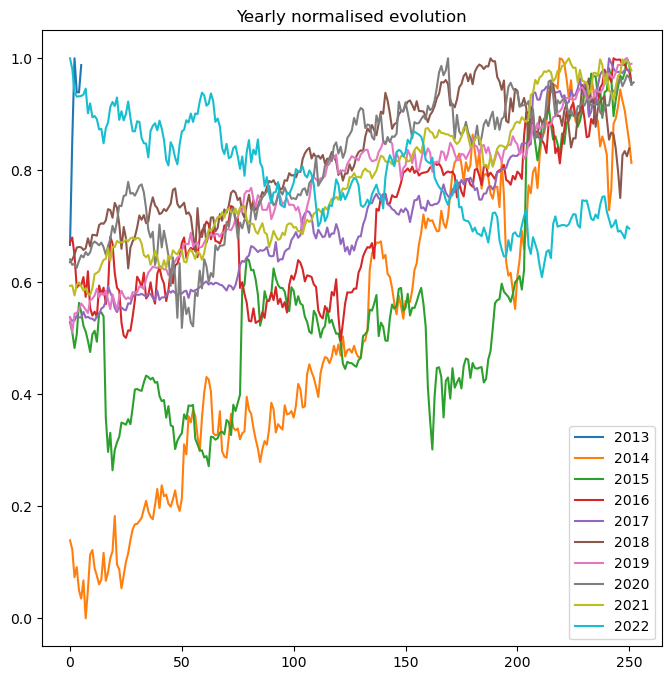

In [145]:
fig, ax = plt.subplots(1,1)
for year in sorted(list(set(df_5.index.year)))[:-1]:
    yearly = df_5.loc[str(year)+"-01-01":str(year+1)+"-01-01"]
    ax.plot(np.array(yearly['Close_1'])/max(yearly['Close_1']), label = str(year))
ax.set_title('Yearly normalised evolution')
ax.legend();

<a id="02"></a> 
# Closing price seasonal decomposition (non stationary data)
[back to top](#top)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

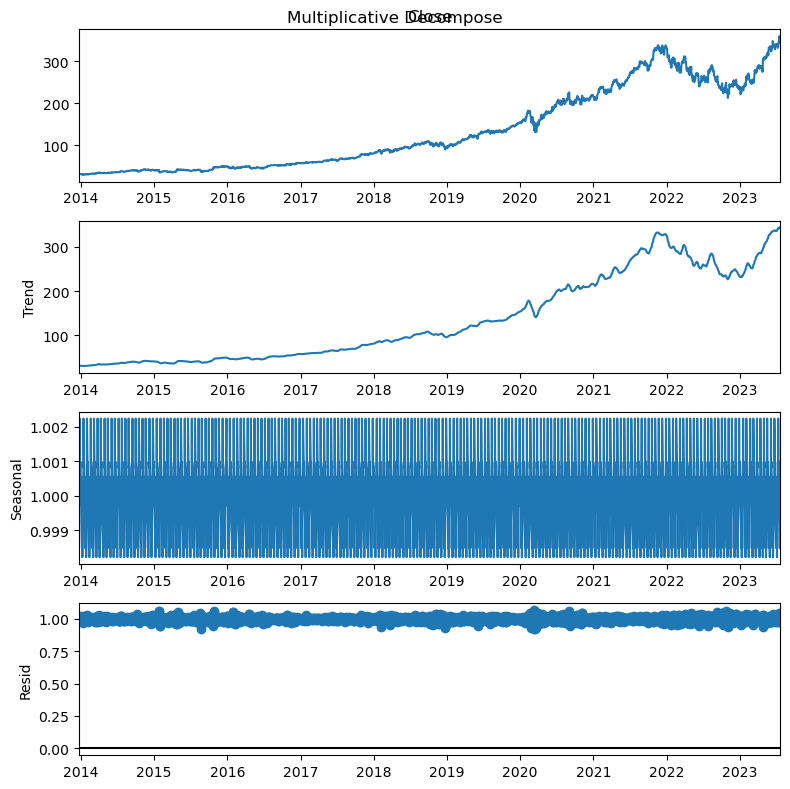

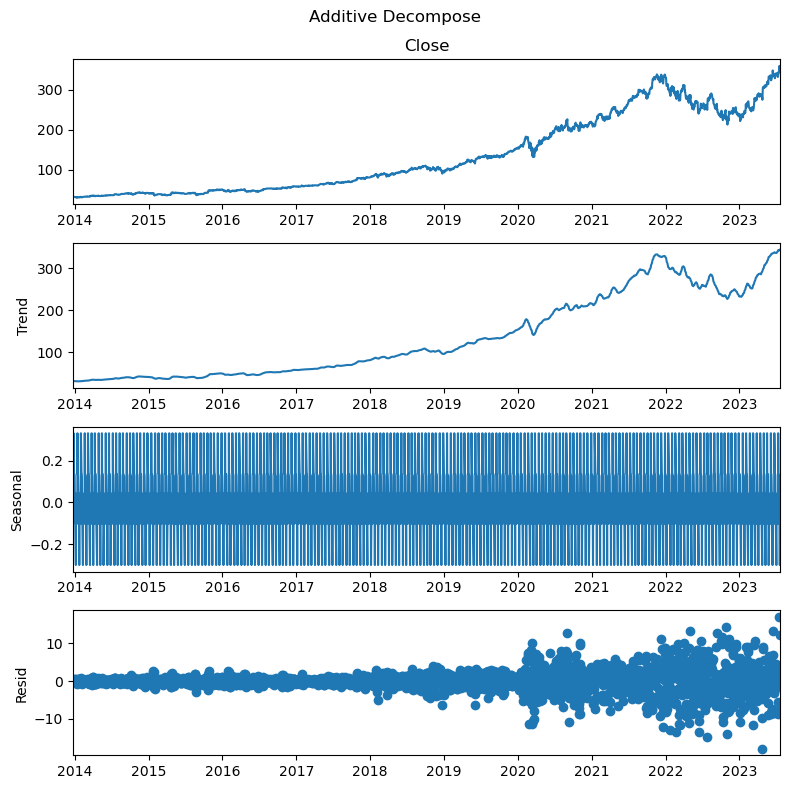

In [147]:
import matplotlib.pyplot as plt
# Multiplicative Decomposition 
result_mul = seasonal_decompose(hist['Close'], model='multiplicative', extrapolate_trend='freq', period=12)

# Additive Decomposition
result_add = seasonal_decompose(hist['Close'], model='additive', extrapolate_trend='freq', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=12)
result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.tight_layout()
plt.show()

In [148]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
2013-12-23 00:00:00-05:00,0.999973,31.228716,0.991554,30.964123
2013-12-24 00:00:00-05:00,0.999718,31.181232,1.005794,31.353073
2013-12-26 00:00:00-05:00,1.002242,31.133747,1.014547,31.657467
2013-12-27 00:00:00-05:00,1.000804,31.086263,1.013480,31.530630
2013-12-30 00:00:00-05:00,1.000989,31.038779,1.014843,31.530630


In [ ]:
Stationarity check

In [149]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(hist['Close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(hist['Close'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.8639858618135986
p-value: 0.9926018651729246
Critial Values:
   1%, -3.4330936501081823
Critial Values:
   5%, -2.8627521045897844
Critial Values:
   10%, -2.5674152545197644

KPSS Statistic: 7.575570
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\arvyd\.conda\envs\DS-Sample\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


if ADF p-value < 0.05 we reject the null hypothesis - the time series possesses a unit root and is non-stationary  
KPSS is used to test for trend stationarity and is the opposite  
ADF 0.99 and KPSS 0.01 indicate non stationary time series  

## Detrend the time series

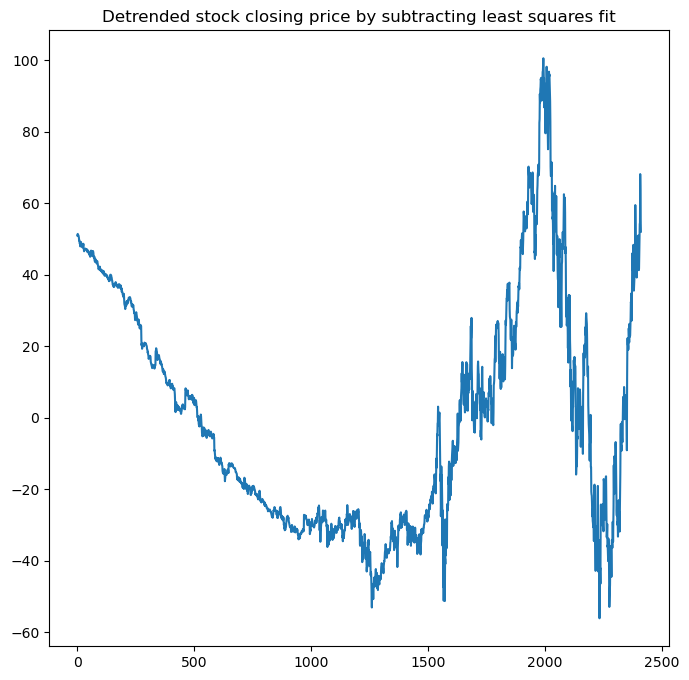

In [178]:
from scipy import signal
detrended = signal.detrend(hist['Close'].values)
plt.plot(detrended)
plt.title('Detrended stock closing price by subtracting least squares fit');

In [179]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(detrended, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(detrended, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.7489397548497132
p-value: 0.40608980726760724
Critial Values:
   1%, -3.4330936501081823
Critial Values:
   5%, -2.8627521045897844
Critial Values:
   10%, -2.5674152545197644

KPSS Statistic: 1.220548
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\arvyd\.conda\envs\DS-Sample\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


if ADF p-value < 0.05 we reject the null hypothesis - the time series possesses a unit root and is non-stationary  
KPSS is used to test for trend stationarity and is the opposite, the null hypothesis - The data is stationary.  
ADF 0.99 and KPSS 0.01 indicate non stationary time series  

Text(0.5, 1.0, 'Closing price detrended by subtracting the trend component')

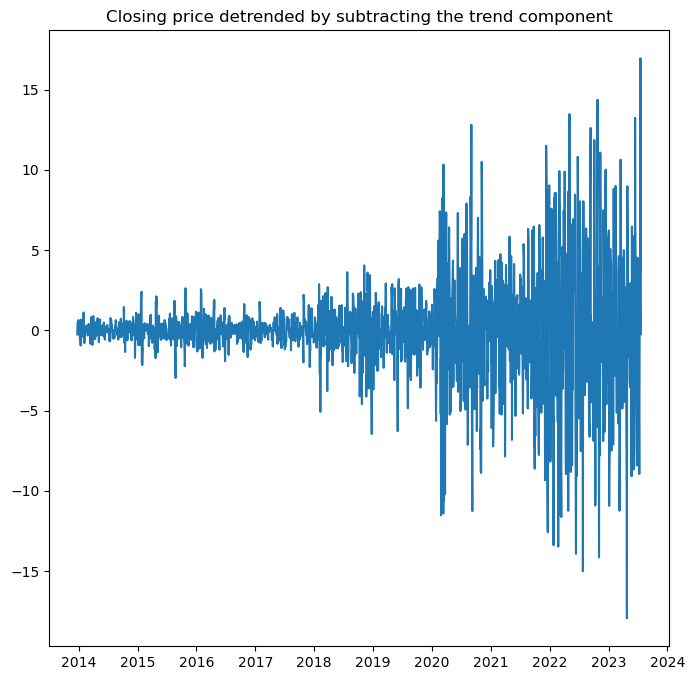

In [176]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(hist['Close'], model='multiplicative', extrapolate_trend='freq', period=12)
detrended = hist['Close'].values - result_mul.trend
plt.plot(detrended)
plt.title('Closing price detrended by subtracting the trend component')

In [ ]:
Deseasonalise time series

[]

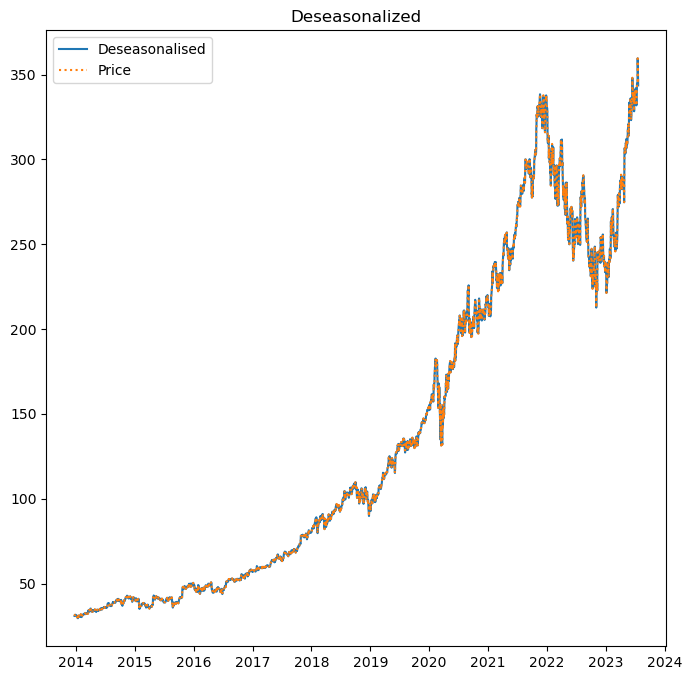

In [170]:
# Time Series Decomposition
result_mul = seasonal_decompose(hist['Close'], model='multiplicative', extrapolate_trend='freq', period = 12)

# Deseasonalize
deseasonalized = hist['Close'].values / result_mul.seasonal

# Plot
plt.plot(deseasonalized, label = 'Deseasonalised')
plt.plot(hist['Close'], linestyle = 'dotted', label = 'Price')
plt.legend()
plt.title('Deseasonalized')
plt.plot()

In [ ]:
Auto correlation dunction (ACF) for seasonality check

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

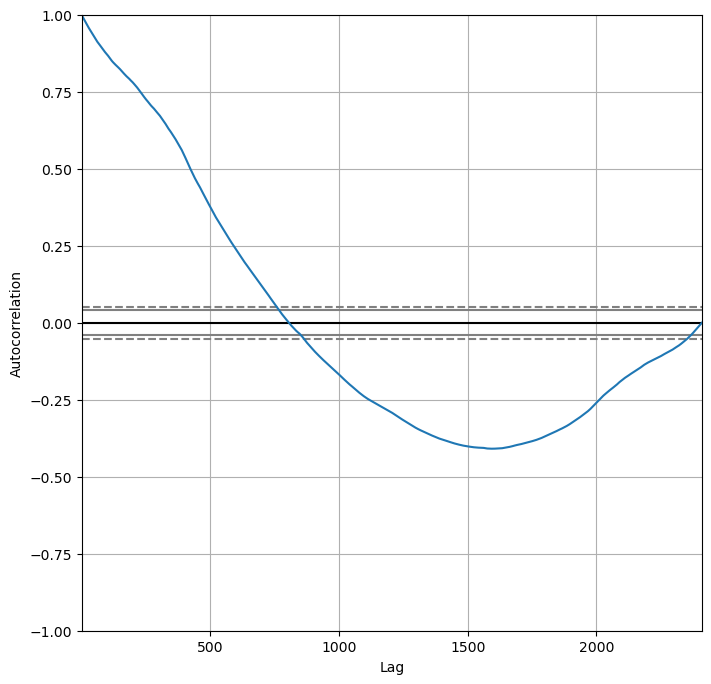

In [172]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(hist['Close'].tolist())

<a id="03"></a> 
# Make Time Series stationary
[back to top](#top)

<a id="04"></a> 
# Seasonal decomposition (stationary data)
[back to top](#top)

# <b><u>This notebook is still work in progress </b></u>